In [1]:

from huggingface_hub import login
login(token="---------")


from google.colab import drive
drive.mount('/content/drive')

!pip install -q transformers torch pillow opencv-python ultralytics pandas

Mounted at /content/drive
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 28.9 MB/s eta 0:00:00


In [2]:
import cv2
import torch
import pandas as pd
from time import time
from transformers import pipeline
from ultralytics import YOLO
from PIL import Image

VIDEO_INPUT = "/content/drive/MyDrive/bulb_sample_video.mp4"
CSV_LOG_PATH = "/content/drive/MyDrive/detection_log.csv"

FRAME_SIZE = (320,240)
FRAME_SKIP = 5
CONF_THRESH = 0.25

CUSTOM_CATEGORIES = [
    "a white lightbulb",
    "a wooden matchstick",
    "a modern gaming console",
    "a wooden chair",
    "a lion in the wild",
    "a computer monitor screen"
]

DEVICE = 0 if torch.cuda.is_available() else -1
DTYPE = torch.float16 if DEVICE==0 else torch.float32

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
print("Loading OWL-ViT...")
owl_detector = pipeline(
    model="google/owlvit-base-patch32",
    task="zero-shot-object-detection",
    device=DEVICE,
    torch_dtype=DTYPE
)

print("Loading YOLOv8...")
yolo_model = YOLO("yolov8n.pt")

Loading OWL-ViT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


model.safetensors:   0%|          | 0.00/613M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/412 [00:00<?, ?it/s]

OwlViTForObjectDetection LOAD REPORT from: google/owlvit-base-patch32
Key                                         | Status     |  | 
--------------------------------------------+------------+--+-
owlvit.text_model.embeddings.position_ids   | UNEXPECTED |  | 
owlvit.vision_model.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


tokenizer_config.json:   0%|          | 0.00/775 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

The image processor of type `OwlViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading YOLOv8...


In [4]:
def detect_owl(frame):
    resized = cv2.resize(frame, FRAME_SIZE)
    pil = Image.fromarray(cv2.cvtColor(resized, cv2.COLOR_BGR2RGB))

    start = time()
    preds = owl_detector(
        pil,
        candidate_labels=CUSTOM_CATEGORIES,
        threshold=CONF_THRESH
    )
    inference_time = time() - start

    boxes=[]
    for p in preds:
        boxes.append({
            "label": p["label"],
            "score": p["score"]
        })

    return boxes, inference_time


def detect_yolo(frame):
    start = time()
    results = yolo_model(frame)[0]
    inference_time = time() - start

    boxes=[]
    for box in results.boxes:
        boxes.append({
            "label": results.names[int(box.cls[0])],
            "score": float(box.conf[0])
        })

    return boxes, inference_time

In [5]:
def run_benchmark():

    cap = cv2.VideoCapture(VIDEO_INPUT)
    if not cap.isOpened():
        raise FileNotFoundError("Video not found.")

    logs=[]
    owl_times=[]
    yolo_times=[]
    frame_idx=0

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if frame_idx % FRAME_SKIP == 0:

            # OWL
            owl_boxes, owl_time = detect_owl(frame)
            owl_times.append(owl_time)

            # YOLO
            yolo_boxes, yolo_time = detect_yolo(frame)
            yolo_times.append(yolo_time)

            # Log detections
            for b in owl_boxes:
                logs.append([frame_idx,"OWL",b["label"],b["score"],owl_time])
            for b in yolo_boxes:
                logs.append([frame_idx,"YOLO",b["label"],b["score"],yolo_time])

        frame_idx+=1

    cap.release()

    df = pd.DataFrame(logs,
        columns=["frame","model","label","score","inference_time"])

    df.to_csv(CSV_LOG_PATH, index=False)

    # Metrics
    owl_avg = sum(owl_times)/len(owl_times)
    yolo_avg = sum(yolo_times)/len(yolo_times)

    print("\n--- PERFORMANCE SUMMARY ---")
    print(f"OWL-ViT Avg Inference Time: {owl_avg:.4f}s")
    print(f"YOLOv8 Avg Inference Time: {yolo_avg:.4f}s")
    print(f"OWL-ViT FPS: {1/owl_avg:.2f}")
    print(f"YOLOv8 FPS: {1/yolo_avg:.2f}")

    return df

Run exp

In [6]:
run_benchmark()


0: 640x384 (no detections), 74.4ms
Speed: 4.1ms preprocess, 74.4ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 potted plants, 1 vase, 9.8ms
Speed: 1.7ms preprocess, 9.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bottle, 2 cups, 2 potted plants, 1 dining table, 1 vase, 12.8ms
Speed: 1.5ms preprocess, 12.8ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bottle, 1 cup, 2 potted plants, 8.7ms
Speed: 2.4ms preprocess, 8.7ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bottle, 2 cups, 3 potted plants, 9.2ms
Speed: 1.7ms preprocess, 9.2ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bottle, 2 cups, 3 potted plants, 6.7ms
Speed: 2.0ms preprocess, 6.7ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 cup, 2 potted plants, 8.7ms
Speed: 1.4ms preprocess, 8.7ms inference, 1.7ms postprocess per i

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset



0: 640x384 1 person, 1 bottle, 2 cups, 2 potted plants, 8.2ms
Speed: 1.6ms preprocess, 8.2ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 1 cat, 3 potted plants, 7.8ms
Speed: 1.6ms preprocess, 7.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 cat, 2 potted plants, 10.1ms
Speed: 1.8ms preprocess, 10.1ms inference, 1.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 cat, 1 potted plant, 1 book, 8.8ms
Speed: 1.5ms preprocess, 8.8ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 persons, 1 cat, 2 potted plants, 6.4ms
Speed: 1.5ms preprocess, 6.4ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 person, 1 cat, 1 cup, 2 potted plants, 1 book, 11.6ms
Speed: 1.8ms preprocess, 11.6ms inference, 2.3ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 3 persons, 1 cat, 1 cup, 2 potted plants, 8.9ms
Speed: 1.9ms 

,frame,model,label,score,inference_time
0,5,YOLO,potted plant,0.583190,0.063585
1,5,YOLO,vase,0.515461,0.063585
2,5,YOLO,potted plant,0.444998,0.063585
3,10,YOLO,potted plant,0.652080,0.024312
4,10,YOLO,dining table,0.360561,0.024312
...,...,...,...,...,...
232,345,YOLO,cup,0.623359,0.020242
233,345,YOLO,knife,0.264664,0.020242
234,350,YOLO,cup,0.539463,0.015806
235,350,YOLO,potted plant,0.300779,0.015806


Analysis

In [7]:
df = pd.read_csv(CSV_LOG_PATH)

print("\nPer-Category Detection Count:")
print(df.groupby(["model","label"]).size())

print("\nAverage Confidence Per Model:")
print(df.groupby("model")["score"].mean())

print("\nADetection Distribution Comparison:")
print(df.groupby("model")["label"].value_counts())


Per-Category Detection Count:
model  label       
YOLO   book             3
       bottle           6
       bowl            13
       cat              8
       cup             25
       dining table     6
       knife            1
       laptop           1
       person          45
       potted plant    97
       refrigerator     1
       vase            31
dtype: int64

Average Confidence Per Model:
model
YOLO    0.479496
Name: score, dtype: float64

ADetection Distribution Comparison:
model  label       
YOLO   potted plant    97
       person          45
       vase            31
       cup             25
       bowl            13
       cat              8
       bottle           6
       dining table     6
       book             3
       knife            1
       laptop           1
       refrigerator     1
Name: count, dtype: int64


OWL-ViT

In [8]:
CUSTOM_CATEGORIES = [
    "a white lightbulb",
    "a glowing bulb",
    "an LED lamp",
    "a ceiling light"
]

df_prompt_test = run_benchmark()


0: 640x384 (no detections), 8.7ms
Speed: 1.5ms preprocess, 8.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 2 potted plants, 1 vase, 8.8ms
Speed: 2.5ms preprocess, 8.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bottle, 2 cups, 2 potted plants, 1 dining table, 1 vase, 11.6ms
Speed: 1.5ms preprocess, 11.6ms inference, 2.2ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bottle, 1 cup, 2 potted plants, 13.1ms
Speed: 1.6ms preprocess, 13.1ms inference, 2.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bottle, 2 cups, 3 potted plants, 9.9ms
Speed: 1.5ms preprocess, 9.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 bottle, 2 cups, 3 potted plants, 6.5ms
Speed: 2.3ms preprocess, 6.5ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 384)

0: 640x384 1 cup, 2 potted plants, 7.8ms
Speed: 1.7ms preprocess, 7.8ms inference, 1.3ms postprocess per i

Accuracy

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv("/content/drive/MyDrive/detection_log.csv")

print(df.head())

   frame model         label     score  inference_time
0      5  YOLO  potted plant  0.583190        0.019649
1      5  YOLO          vase  0.515461        0.019649
2      5  YOLO  potted plant  0.444998        0.019649
3     10  YOLO  potted plant  0.652080        0.025640
4     10  YOLO  dining table  0.360561        0.025640


   model            label  count
0    OWL  a ceiling light      1
1   YOLO             book      3
2   YOLO           bottle      6
3   YOLO             bowl     13
4   YOLO              cat      8
5   YOLO              cup     25
6   YOLO     dining table      6
7   YOLO            knife      1
8   YOLO           laptop      1
9   YOLO           person     45
10  YOLO     potted plant     97
11  YOLO     refrigerator      1
12  YOLO             vase     31


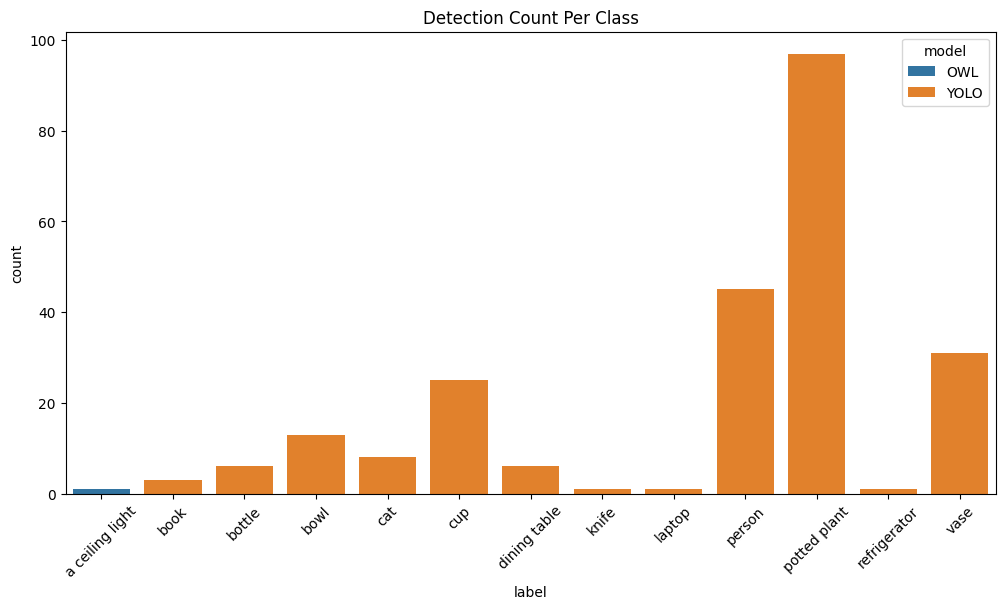

In [10]:
count_table = df.groupby(["model","label"]).size().reset_index(name="count")
print(count_table)

# Visualize
plt.figure(figsize=(12,6))
sns.barplot(data=count_table, x="label", y="count", hue="model")
plt.xticks(rotation=45)
plt.title("Detection Count Per Class")
plt.show()

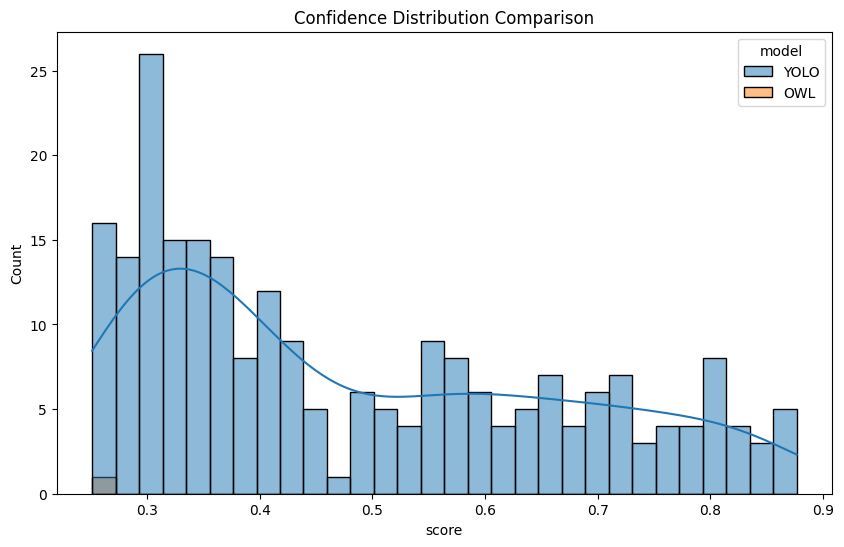

       count      mean       std       min       25%       50%       75%  \
model                                                                      
OWL      1.0  0.259638       NaN  0.259638  0.259638  0.259638  0.259638   
YOLO   237.0  0.479496  0.183965  0.251098  0.318264  0.414408  0.627734   

            max  
model            
OWL    0.259638  
YOLO   0.876585  


In [11]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="score", hue="model", bins=30, kde=True)
plt.title("Confidence Distribution Comparison")
plt.show()

print(df.groupby("model")["score"].describe())

In [12]:
owl_df = df[df["model"]=="OWL"]

prompt_counts = owl_df.groupby("label").size().reset_index(name="count")
print(prompt_counts)

             label  count
0  a ceiling light      1


Exceptions

In [14]:
low_conf = df[df["score"] < 0.3]
print("Potential False Positives:")
print(low_conf.groupby("model").size())

Potential False Positives:
model
OWL      1
YOLO    39
dtype: int64


In [15]:
print(df.groupby(["model","label"]).size().sort_values())

model  label          
OWL    a ceiling light     1
YOLO   knife               1
       refrigerator        1
       laptop              1
       book                3
       bottle              6
       dining table        6
       cat                 8
       bowl               13
       cup                25
       vase               31
       person             45
       potted plant       97
dtype: int64


Statical Comparision

In [16]:
from scipy.stats import ttest_ind

owl_scores = df[df["model"]=="OWL"]["score"]
yolo_scores = df[df["model"]=="YOLO"]["score"]

t_stat, p_value = ttest_ind(owl_scores, yolo_scores)
print("T-test p-value:", p_value)

T-test p-value: 0.23422653839851673
